In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from learntools.time_series.utils import plot_periodogram, seasonal_plot

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
                      parse_dates=['date']).dropna()
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
                       parse_dates=['date']).dropna()
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv',
                  parse_dates=['date']).dropna()
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
#transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv',
                       parse_dates=['date']).dropna()
#sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

train['date'] = train.date.dt.to_period('D')
test['date'] = test.date.dt.to_period('D')
holidays_events['date'] = holidays_events['date'].dt.to_period('D')
oil['date'] = oil.date.dt.to_period('D')

In [2]:
mn = train.date.min()
mx = train.date.max()
print(mx, mn)
mn = test.date.min()
mx = test.date.max()
print(mx, mn)

2017-08-15 2013-01-01
2017-08-31 2017-08-16


Отобразим на графике наши данные и их усреднение за год. 
Видимый тренд будем учитывать как линейный.

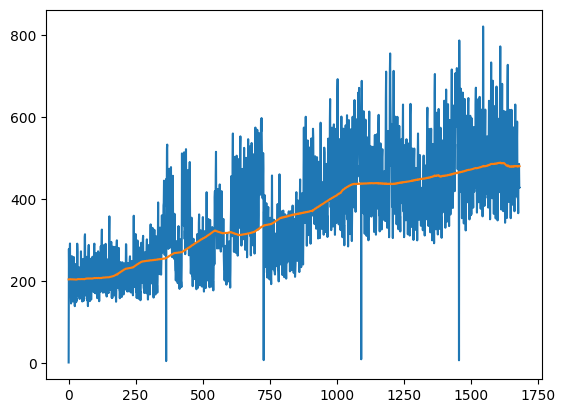

In [3]:
moving_average = train.groupby('date').sales.mean().rolling(
    window=365,
    center=True,
    min_periods=183
).mean()  

plt.plot(range(len(moving_average)), train.groupby('date').sales.mean())
plt.plot(range(len(moving_average)), (moving_average))


plt.show()

Добавляем столбец с ценами на топливо на каждый день к данным для обучения.
Сортируем данные по датам, разделяем их на X и y.

In [4]:
oil.set_index('date', inplace=True)
train.set_index('date', inplace=True)
train = train.join(oil, on=['date']).reset_index()

train.sort_values(by='date')

X = train.drop('sales', axis = 1)
y = train.sales

Строим периодограмму для определения сезонности. Видим отчетливую ежегодную и еженедельную зависимости. 

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

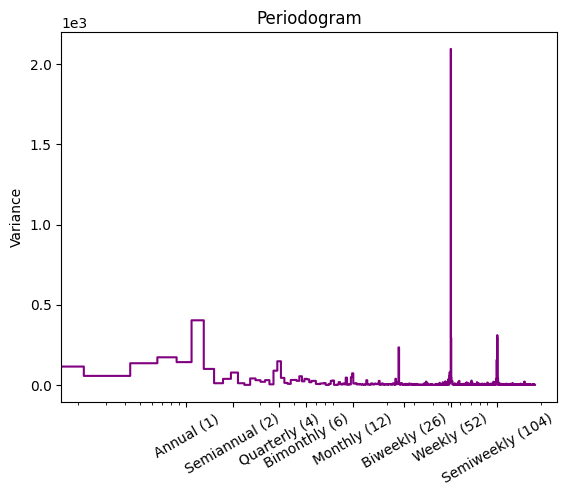

In [5]:
plot_periodogram(train.groupby('date').sales.mean())

Ежегодную сезонность моделируем с помощью метода рядов Фурье, 
еженедельную с помощью индикаторов.

In [6]:
fourier = CalendarFourier(freq="YE", order=10) 

dp = DeterministicProcess(
    index=X.date.unique(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
#    drop=True,                   # drop terms to avoid collinearity
)

X1 = dp.in_sample()  # create features for dates in tunnel.index

X = X.join(X1, on='date')

DataFrame holidays содержит информацию, какие магазины затронуты каждым праздником

In [7]:
stores_count = len(stores.store_nbr.unique())

holidays = pd.DataFrame(columns = ['date', 'type', 'locale', 'transferred', 'store_nbr'])
for i in range(len(holidays_events)):
    
    new = pd.DataFrame(holidays_events.iloc[[i]])
    new.drop(['description'], axis = 1, inplace=True)
    new.dropna(axis=1, how='all', inplace=True)
    holidays.dropna(axis=1, how='all', inplace=True)
    
    if holidays_events.iloc[[i]].locale.item() == 'National':

        for j in range(stores_count):

            new['store_nbr'] = [j]
            holidays = pd.concat([holidays, new], ignore_index=True)
            
    elif holidays_events.iloc[[i]].locale.item() == 'Local':
        for j in range(stores_count):
            if stores.loc[j, 'city'] == holidays_events.iloc[[i]].locale_name.item():
                new['store_nbr'] = [j]
                holidays = pd.concat([holidays, new], ignore_index=True)
                
    else:
        for j in range(stores_count):
            if stores.loc[j, 'state'] == holidays_events.iloc[[i]].locale_name.item():
                new['store_nbr'] = [j]
                holidays = pd.concat([holidays, new], ignore_index=True)
                
        
        
holidays.reset_index(drop=True, inplace=True)
holidays.drop(['locale_name'], axis = 1, inplace=True)

В один день один и тот же магазин могут затронуть несколько праздников, из-за чего при попытке соединить по дате и номеру магазина holidays и trein/test могут появится лишние строки.
Поэтому преобразуем holidays. Создаем dummies для ['locale', 'type'], ведь нам важно, есть ли локальный праздник, есть ли региональный и т. д., и соединяем строки для них с помощью or. Для ['type_Work Day', 'transferred'], наоборот, важно, есть ли хоть один неперенесенный праздник или является ли день выходным хоть из-за какого-то события, поэтому соединяем с помощью and.

In [8]:
holidays = pd.get_dummies(holidays, columns=['locale', 'type'])
list_or = ['locale_Local', 'locale_National', 'locale_Regional', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Transfer']
list_and = ['type_Work Day', 'transferred']
for i in range(len(holidays)):
    for j in range(i + 1, len(holidays)):
        if holidays.loc[i, 'date'] != holidays.loc[j, 'date']:
            break
        if holidays.loc[i, 'store_nbr'] == holidays.loc[j, 'store_nbr']:
            new = holidays.loc[i].copy()
            for k in list_or:
                new.loc[k] = new.loc[k] or holidays.loc[j, k]
            for k in list_and:
                new.loc[k] = new.loc[k] and holidays.loc[j, k]
            holidays.loc[i] = new
            holidays.loc[j] = new
            #holidays.drop([j])
            
holidays.drop_duplicates(inplace=True, ignore_index=True)


Проверяем, чтобы по каждому совпадению даты и номера магазина осталась лишь одна строка.

In [9]:
m = holidays.copy()
for i in range(len(m)):
    for j in range(i + 1, len(m)):
        if m.loc[i, 'date'] != m.loc[j, 'date']:
            break
        if m.loc[i, 'store_nbr'] == m.loc[j, 'store_nbr']:
            print(m.loc[i])
            print(m.loc[j])

Добавляем столбцы из holidays в наш датасет.

In [10]:
X.set_index(['date', 'store_nbr'], inplace=True)
holidays.set_index(['date', 'store_nbr'], inplace=True)
X = X.join(holidays, on=['date', 'store_nbr']).reset_index()

**Удалить дубликаты если один магазин и одна дата но разные local и вообще все в one-hot!!!!**

По умолчанию считаем, что есть даты в holidays нет, то и празднка в этот день тоже. Заполняем отсутствующие данные с помощью False.

In [11]:
X.fillna(False, inplace=True)
X.infer_objects(copy=False)

/tmp/ipykernel_18/1125860448.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna(False, inplace=True)
/tmp/ipykernel_18/1125860448.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(False, inplace=True)


,date,store_nbr,id,family,onpromotion,dcoilwtico,const,trend,"s(2,7)","s(3,7)",...,transferred,locale_Local,locale_National,locale_Regional,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
0,2013-01-01,1,0,AUTOMOTIVE,0,False,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,False
1,2013-01-01,1,1,BABY CARE,0,False,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,False
2,2013-01-01,1,2,BEAUTY,0,False,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,False
3,2013-01-01,1,3,BEVERAGES,0,False,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,False
4,2013-01-01,1,4,BOOKS,0,False,1.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,3000883,POULTRY,0,47.57,1.0,1684.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3000884,2017-08-15,9,3000884,PREPARED FOODS,1,47.57,1.0,1684.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3000885,2017-08-15,9,3000885,PRODUCE,148,47.57,1.0,1684.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3000886,2017-08-15,9,3000886,SCHOOL AND OFFICE SUPPLIES,8,47.57,1.0,1684.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


Удаляем столбец с датами, чтобы избежать коллинеарности, ведь линейный тренд является по сути time_steps.
Используем one-hot кодирование для family, чтобы избавиться от строкового формата значений.

In [12]:
X = X.drop('date', axis = 1)
X = pd.get_dummies(X, columns=['family'])
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, shuffle=False)

Используем линейную регрессию как базовую модель для дальнейшего сравнения.

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    y_pred[i] = max(0, y_pred[i])

score = model.score(X_test, y_test)
score

0.5533804385331569

Строим график усредненных продаж по всем магазинам и типам товаров в зависимости от даты. Сравниваем данные нам значения и полученные моделью.

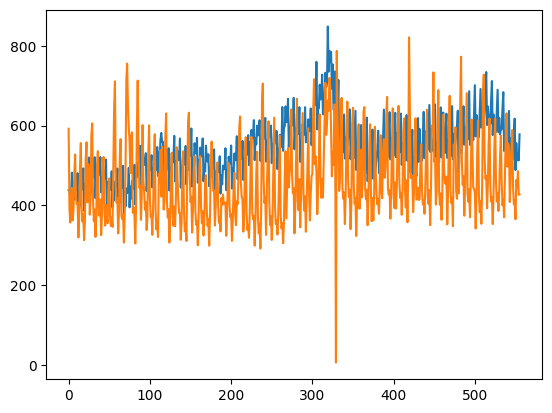

In [14]:
avg_pred = pd.DataFrame({'trend': X_test.trend, 'y': y_pred}).groupby('trend').y.mean()
avg_test = pd.DataFrame({'trend': X_test.trend, 'y': y_test}).groupby('trend').y.mean()
plt.plot(range(len(avg_pred)), avg_pred)
plt.plot(range(len(avg_test)), avg_test)
plt.show()

Считаем необходимую метрику.

In [15]:
metric = sklearn.metrics.mean_squared_log_error(y_test, y_pred)
metric

6.790973827402373

Обучаем модель ужа на всех данных из train, и применяем ее к test (который предварительно обрабатываем так же, как и train до этого).

In [16]:
new_model = LinearRegression()
new_model.fit(X, y)


test.set_index('date', inplace=True)
test = test.join(oil, on=['date']).reset_index()

fourier = CalendarFourier(freq="YE", order=10) 
test_dp = DeterministicProcess(
    index=test.date.unique(),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier]#,  # annual seasonality (fourier)
#    drop=True,                   # drop terms to avoid collinearity
)

X_f = test_dp.in_sample()  # create features for dates in tunnel.index
test = test.join(X_f, on='date')

test.set_index(['date', 'store_nbr'], inplace=True)
#h = holidays.copy()
#holidays.set_index(['date', 'store_nbr'], inplace=True)

test = test.join(holidays, on=['date', 'store_nbr']).reset_index()
test.head()

test.fillna(False, inplace=True)
test.infer_objects(copy=False)
#test['date'] = test['date'].astype('int64')
test = pd.get_dummies(test, columns=['family'])

test.drop('date', axis = 1, inplace=True)
test['trend'] += X.trend.max()

predicted = new_model.predict(test)
for i in range(len(predicted)):
    predicted[i] = max(0, predicted[i])


/tmp/ipykernel_18/307533528.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test.fillna(False, inplace=True)
/tmp/ipykernel_18/307533528.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(False, inplace=True)


Немного графиков полученного результата на тестовых данных.

16


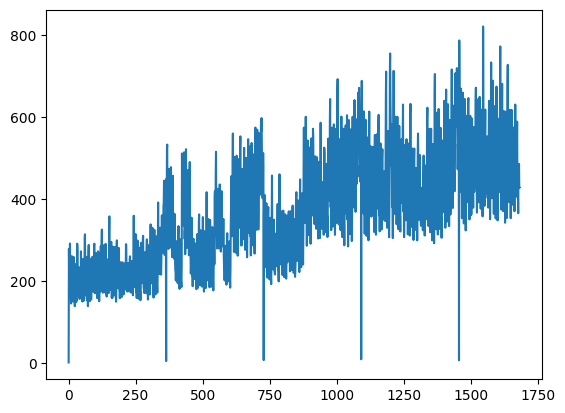

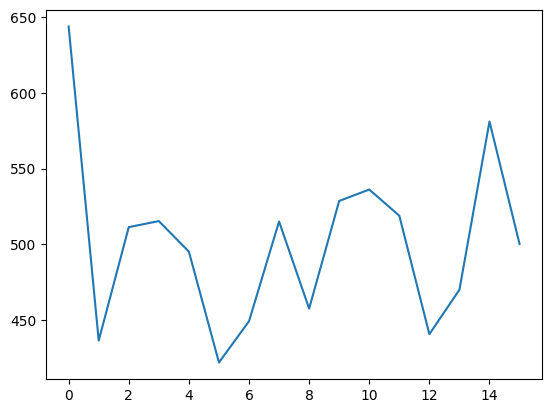

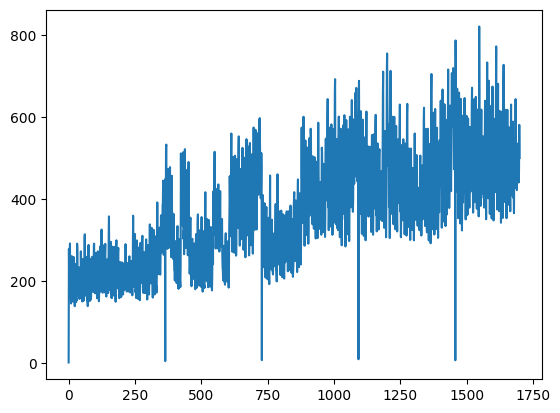

In [17]:
avg_x = pd.DataFrame({'trend': X.trend, 'y': y}).groupby('trend').y.mean()
avg_test = pd.DataFrame({'trend': test.trend, 'y': predicted}).groupby('trend').y.mean()
print(len(avg_test))
plt.plot(range(len(avg_x)), avg_x)
plt.show()
plt.plot(range(len(avg_test)), avg_test)
plt.show()
plt.plot(range(len(avg_test) + len(avg_x)), pd.concat([avg_x, avg_test]))
plt.show()

Сохраняем ответ в требуемом формате.

In [18]:
df_predicted = pd.DataFrame({'id':range(len(train), len(train) + len(test)), 'sales': predicted}).set_index('id')
df_predicted.to_csv('sample_submission')